Use the library of identified sequences to detect the feature in each run. Build a table of each feature's attributes and their decoy.

In [51]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import sqlite3
import peakutils
import matplotlib.pyplot as plt

In [52]:
FILE_IDX_FOR_ANALYSIS = 0

In [53]:
SEQUENCE_FILE_COUNTS_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/sequence-charge-file-counts-df.pkl'

In [54]:
sequence_file_counts_df = pd.read_pickle(SEQUENCE_FILE_COUNTS_FILE_NAME)

In [188]:
sequence_file_counts_df[sequence_file_counts_df.file_idxs.apply(lambda x: 0 not in x)].sample(n=20)

,sequence,charge,number_of_files,file_idxs
18011,LVPLNQESVEER,2,1,[1]
2330,ATISNDGATILK,2,2,"[2, 15]"
21367,QPAPGGGGGGGPSPCGPGGGGR,2,1,[12]
22350,Q[-17.0265]SLSHMLSAK,2,11,"[1, 7, 8, 9, 11, 12, 13, 14, 15, 17, 18]"
23975,SLEPLPSSGPDFGGLGEEAEFVEVEPEAK,3,7,"[5, 10, 12, 14, 15, 17, 18]"
28330,VLDGLHNELQTIGFQIETIGK,3,1,[17]
8135,FFLSHPAYR,2,9,"[1, 2, 10, 11, 12, 13, 14, 17, 18]"
12792,IEGYEDQVLITEHGDLGNGK,3,9,"[2, 6, 7, 10, 11, 12, 17, 18, 19]"
12347,HVVLGAIENK,2,5,"[1, 2, 11, 13, 15]"
23492,SETCNEDLAGTTDEK,2,1,[2]


In [324]:
SEQUENCE_ROW_IDX_FOR_ANALYSIS = 26857

In [325]:
EXPERIMENT_SEQUENCE_ATTRIBS_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/training-sets/experiment-sequence-charge-attribs-df.pkl'

In [326]:
experiment_sequence_attribs_df = pd.read_pickle(EXPERIMENT_SEQUENCE_ATTRIBS_FILE_NAME)

In [327]:
experiment_sequence_attribs_df.head()

,sequence,charge,theoretical_mz,experiment_scan,experiment_scan_peak_width,experiment_rt,experiment_rt_peak_width,experiment_intensity
0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1184.1049,73.911301,57.626667,602.012681,18.706667,108754.444444
1,AAAAAAAAAPAAAATAPTTAATTAATAAQ,3,789.7394,335.868469,56.366667,609.864140,5.030000,29377.333333
2,AAAAAAAAVPSAGPAGPAPTSAAGR,2,1016.0286,160.291329,64.555556,489.973155,6.357111,58456.622222
3,AAAAALSQQQSLQER,2,785.9075,496.361511,45.912500,375.039574,6.140000,57092.250000
4,AAAAATVVPPMVGGPPFVGPVGFGPGDR,3,864.1171,707.537580,48.382593,1039.861047,16.666296,50988.518519


In [328]:
# use the run-0 model to find AAAAATVVPPMVGGPPFVGPVGFGPGDR, charge 3 in the raw data of the file idx
RUN_MZ_MODEL_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/trained-models/file-{}-mz-model.pkl'.format(FILE_IDX_FOR_ANALYSIS)
RUN_SCAN_MODEL_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/trained-models/file-{}-scan-model.pkl'.format(FILE_IDX_FOR_ANALYSIS)
RUN_RT_MODEL_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/trained-models/file-{}-rt-model.pkl'.format(FILE_IDX_FOR_ANALYSIS)

In [329]:
with open(RUN_MZ_MODEL_FILE_NAME, 'rb') as file:
    mz_estimator = pickle.load(file)
with open(RUN_SCAN_MODEL_FILE_NAME, 'rb') as file:
    scan_estimator = pickle.load(file)
with open(RUN_RT_MODEL_FILE_NAME, 'rb') as file:
    rt_estimator = pickle.load(file)

In [330]:
# gather the sequence attributes to plug into each model
sequence_df = pd.DataFrame(experiment_sequence_attribs_df.iloc[SEQUENCE_ROW_IDX_FOR_ANALYSIS]).transpose()

In [331]:
sequence_df

,sequence,charge,theoretical_mz,experiment_scan,experiment_scan_peak_width,experiment_rt,experiment_rt_peak_width,experiment_intensity
26857,TTVLLADINDFNTVNEIYK,2,1091.56,109.194,59.7732,977.328,10.2024,237048


In [332]:
sequence_estimation_attribs_df = sequence_df[['theoretical_mz','experiment_rt','experiment_scan','experiment_intensity']]
sequence_estimation_attribs = sequence_estimation_attribs_df.values

In [333]:
sequence_estimation_attribs

array([[1091.5615, 977.3281511821318, 109.19366121522847,
        237048.34210526315]], dtype=object)

In [334]:
# estimate the raw monoisotopic m/z
mz_delta_estimated = mz_estimator.predict(sequence_estimation_attribs)
estimated_monoisotopic_mz = sequence_estimation_attribs_df.iloc[0].theoretical_mz - mz_delta_estimated[0]
estimated_monoisotopic_mz

1092.0556180836163

In [335]:
# estimate the raw monoisotopic scan
scan_estimated = scan_estimator.predict(sequence_estimation_attribs)
estimated_scan_apex = scan_estimated[0]
estimated_scan_apex

108.94753940935118

In [336]:
# estimate the raw monoisotopic RT
rt_estimated = rt_estimator.predict(sequence_estimation_attribs)
estimated_rt_apex = rt_estimated[0]
estimated_rt_apex

973.9890645650235

Look in the raw data for a feature at these coordinates

In [337]:
# the width to use for intensity descent, in m/z
MZ_TOLERANCE_PPM = 40  # +/- this amount
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4
MS1_PEAK_DELTA = estimated_monoisotopic_mz * MZ_TOLERANCE_PERCENT / 100

In [338]:
MS1_PEAK_DELTA

0.043682224723344654

In [339]:
# Mass difference between Carbon-12 and Carbon-13 isotopes, in Da. For calculating the spacing between isotopic peaks.
CARBON_MASS_DIFFERENCE = 1.003355

# the collision energy to distinguish ms1 and ms2 frames
MS1_COLLISION_ENERGY = 10

In [340]:
# takes a numpy array of intensity, and another of mz
def mz_centroid(_int_f, _mz_f):
    return ((_int_f/_int_f.sum()) * _mz_f).sum()

In [341]:
# ms1_peaks_a is a numpy array of [mz,intensity]
# returns a numpy array of [mz_centroid,summed_intensity]
def ms1_intensity_descent(ms1_peaks_a):
    # intensity descent
    ms1_peaks_l = []
    while len(ms1_peaks_a) > 0:
        # find the most intense point
        max_intensity_index = np.argmax(ms1_peaks_a[:,1])
        peak_mz = ms1_peaks_a[max_intensity_index,0]
        peak_mz_lower = peak_mz - MS1_PEAK_DELTA
        peak_mz_upper = peak_mz + MS1_PEAK_DELTA

        # get all the raw points within this m/z region
        peak_indexes = np.where((ms1_peaks_a[:,0] >= peak_mz_lower) & (ms1_peaks_a[:,0] <= peak_mz_upper))[0]
        if len(peak_indexes) > 0:
            mz_cent = mz_centroid(ms1_peaks_a[peak_indexes,1], ms1_peaks_a[peak_indexes,0])
            summed_intensity = ms1_peaks_a[peak_indexes,1].sum()
            ms1_peaks_l.append((mz_cent, summed_intensity))
            # remove the raw points assigned to this peak
            ms1_peaks_a = np.delete(ms1_peaks_a, peak_indexes, axis=0)
    return np.array(ms1_peaks_l)


In [342]:
NUMBER_OF_ISOTOPES = 7     # the number of isotopes to look for in the m/z dimension - the theoretical model includes 7 (the monoisotopic plus 6 isotopes)

expected_spacing_mz = CARBON_MASS_DIFFERENCE / sequence_df.iloc[0].charge

In [343]:
# distance for looking either side of the scan and RT apex
RT_WIDTH = sequence_df.iloc[0].experiment_rt_peak_width
SCAN_WIDTH = sequence_df.iloc[0].experiment_scan_peak_width

In [344]:
feature_region_mz_lower = estimated_monoisotopic_mz - MS1_PEAK_DELTA
feature_region_mz_upper = estimated_monoisotopic_mz + (NUMBER_OF_ISOTOPES * expected_spacing_mz) + MS1_PEAK_DELTA
scan_lower = estimated_scan_apex - (2 * SCAN_WIDTH)
scan_upper = estimated_scan_apex + (2 * SCAN_WIDTH)
rt_lower = estimated_rt_apex - (2 * RT_WIDTH)
rt_upper = estimated_rt_apex + (2 * RT_WIDTH)
print("mz: {}-{}, scan: {}-{}, rt: {}-{}".format(round(feature_region_mz_lower,4), round(feature_region_mz_upper,4), int(scan_lower), int(scan_upper), round(rt_lower,1), round(rt_upper,1)))

mz: 1092.0119-1095.611, scan: -10-228, rt: 953.6-994.4


In [345]:
# find the converted database file name for file idx 0
MAPPING_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/percolator_mapping_df.pkl'
mapping_df = pd.read_pickle(MAPPING_FILE_NAME)

In [346]:
run_name = mapping_df[mapping_df.file_idx == FILE_IDX_FOR_ANALYSIS].iloc[0].run_name
run_name

'190719_Hela_Ecoli_1to3_06-recalibrated'

In [347]:
db_name = run_name.replace('-recalibrated', '-converted.sqlite')

In [348]:
CONVERTED_DATABASE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/converted-databases/{}'.format(db_name)
CONVERTED_DATABASE_NAME

'/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/converted-databases/190719_Hela_Ecoli_1to3_06-converted.sqlite'

In [349]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
ms1_frame_properties_df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where retention_time_secs >= {} and retention_time_secs <= {} and collision_energy == {} order by retention_time_secs".format(rt_lower, rt_upper, MS1_COLLISION_ENERGY), db_conn)
db_conn.close()
ms1_frame_ids = tuple(ms1_frame_properties_df.frame_id)

In [350]:
# extract the raw data within this area of interest
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
feature_region_raw_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {} and frame_id in {}".format(feature_region_mz_lower, feature_region_mz_upper, scan_lower, scan_upper, rt_lower, rt_upper, ms1_frame_ids), db_conn)
db_conn.close()

In [351]:
sequence_name = sequence_df.iloc[0].sequence
sequence_charge = sequence_df.iloc[0].charge

In [352]:
# a wider view for context
feature_region_mz_wide_lower = feature_region_mz_lower - 1
feature_region_mz_wide_upper = feature_region_mz_upper + 1
scan_wide_lower = scan_lower - 30
scan_wide_upper = scan_upper + 30
rt_wide_lower = estimated_rt_apex - 1
rt_wide_upper = estimated_rt_apex + 1

# extract the raw data within this area of interest
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
wide_feature_region_raw_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {} and frame_id in {}".format(feature_region_mz_wide_lower, feature_region_mz_wide_upper, scan_wide_lower, scan_wide_upper, rt_wide_lower, rt_wide_upper, ms1_frame_ids), db_conn)
db_conn.close()

In [353]:
isotope_peaks_l = []
isotope_raw_points_l = []
# derive peaks for the monoisotopic and the isotopes
for isotope_idx in range(NUMBER_OF_ISOTOPES):
    estimated_isotope_midpoint = estimated_monoisotopic_mz + (isotope_idx * expected_spacing_mz)
    isotope_mz_lower = estimated_isotope_midpoint - MS1_PEAK_DELTA
    isotope_mz_upper = estimated_isotope_midpoint + MS1_PEAK_DELTA
    isotope_raw_points_df = feature_region_raw_points_df[(feature_region_raw_points_df.mz >= isotope_mz_lower) & (feature_region_raw_points_df.mz <= isotope_mz_upper)]
    isotope_raw_points_l.append(isotope_raw_points_df)
    # perform intensity descent to get the peak for the isotope
    isotope_raw_points_a = isotope_raw_points_df[['mz','intensity']].to_numpy()
    isotope_peaks_a = ms1_intensity_descent(isotope_raw_points_a)
    if len(isotope_peaks_a) == 0:
        isotope_peaks_a = np.array([(estimated_isotope_midpoint,0)])
    isotope_peaks_l.append(isotope_peaks_a[:1,:])  # take the first row
isotope_peaks_df = pd.DataFrame(np.concatenate(isotope_peaks_l), columns=['mz_centroid','summed_intensity'])

In [354]:
isotope_peaks_df

,mz_centroid,summed_intensity
0,1092.059230,308039.0
1,1092.563076,296593.0
2,1093.061744,232970.0
3,1093.568429,480202.0
4,1094.079380,2480557.0
5,1094.580580,4178436.0
6,1095.081329,3603297.0


In [355]:
len(isotope_raw_points_l)

7

In [356]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

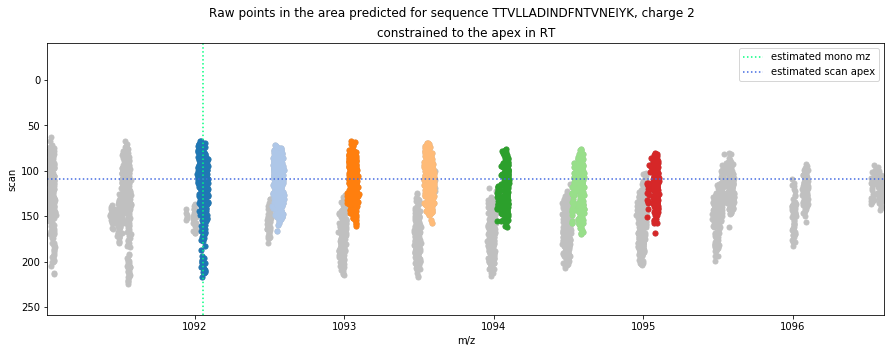

In [357]:
f, ax = plt.subplots()
ax.plot(wide_feature_region_raw_points_df.mz, wide_feature_region_raw_points_df.scan, marker='o', color='silver', linestyle='', ms=5)
for idx,isotope_raw_df in enumerate(isotope_raw_points_l):
    visualise_df = isotope_raw_df[(isotope_raw_df.retention_time_secs >= rt_wide_lower) & (isotope_raw_df.retention_time_secs <= rt_wide_upper)]
    ax.plot(visualise_df.mz, visualise_df.scan, marker='o', color=tableau20[idx], linestyle='', ms=5)
plt.axvline(x=estimated_monoisotopic_mz, linestyle=':', color='springgreen', label='estimated mono mz')
plt.axhline(y=estimated_scan_apex, linestyle=':', color='royalblue', label='estimated scan apex')
plt.xlabel('m/z')
plt.ylabel('scan')
plt.legend(loc='best')
plt.gca().invert_yaxis()
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Raw points in the area predicted for sequence {}, charge {}'.format(sequence_name, sequence_charge))
plt.title('constrained to the apex in RT')
plt.xlim((feature_region_mz_wide_lower,feature_region_mz_wide_upper))
plt.ylim((scan_wide_upper,scan_wide_lower))
plt.margins(0.06)
plt.show()

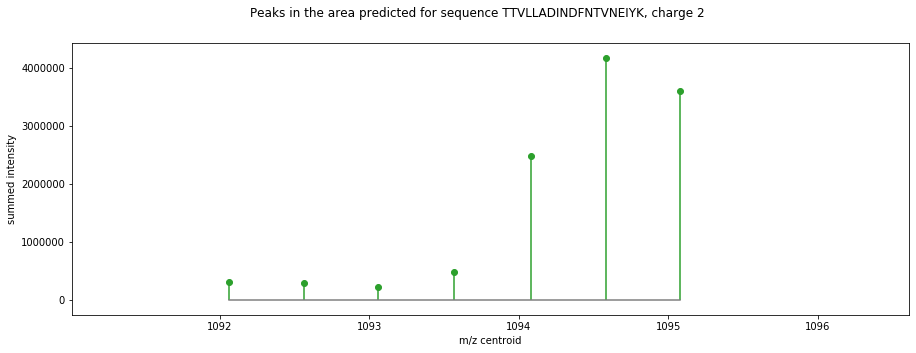

In [358]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(isotope_peaks_df.mz_centroid, isotope_peaks_df.summed_intensity, 'g', use_line_collection=True)
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('m/z centroid')
plt.ylabel('summed intensity')
plt.xlim((feature_region_mz_wide_lower,feature_region_mz_wide_upper))
f.set_figheight(5)
f.set_figwidth(15)
plt.margins(0.06)
plt.suptitle('Peaks in the area predicted for sequence {}, charge {}'.format(sequence_name, sequence_charge))
plt.show()

Gather the raw points belonging to the monoisotopic peak

In [359]:
mono_raw_points_df = isotope_raw_points_l[0]

Collapse the points onto the mobility dimension

In [360]:
scan_df = mono_raw_points_df.groupby(['scan'], as_index=False).intensity.sum()

In [361]:
scan_df.sort_values(by=['scan'], ascending=True, inplace=True)

In [362]:
mobility_curve_fit = False
try:
    gaussian_params = peakutils.peak.gaussian_fit(scan_df.scan.values, scan_df.intensity.values, center_only=False)
    scan_apex_fitted = gaussian_params[1]
    scan_side_width = 2 * abs(gaussian_params[2])  # number of standard deviations either side of the apex
    scan_lower = scan_apex_fitted - scan_side_width
    scan_upper = scan_apex_fitted + scan_side_width
    g = peakutils.peak.gaussian(scan_df.scan, gaussian_params[0], gaussian_params[1], gaussian_params[2])
    mobility_curve_fit = True
    if (scan_apex_fitted >= wide_scan_lower) and (scan_apex_fitted <= wide_scan_upper):
        mobility_curve_fit = True
except:
    pass

# if we couldn't fit a curve to the mobility dimension, take the intensity-weighted centroid
if not mobility_curve_fit:
    print("could not fit a gaussian to the points - calculating the centroid")
    scan_apex_centroid = mz_centroid(scan_df.intensity.to_numpy(), scan_df.scan.to_numpy())
    scan_apex_max = scan_df.loc[scan_df.intensity.idxmax()].scan

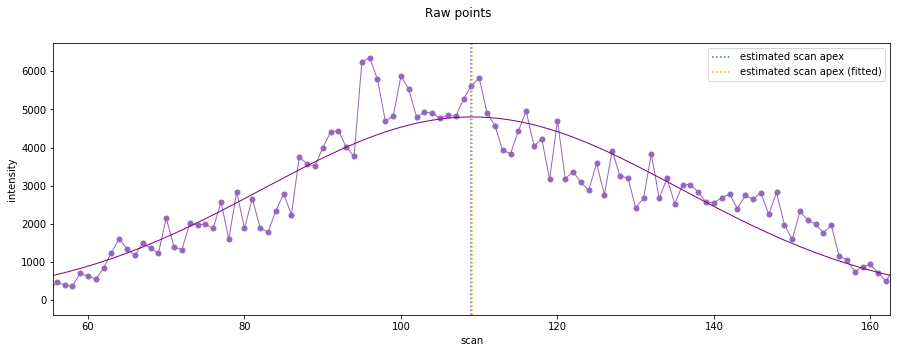

In [363]:
# visualise the monoisotopic peak in the scan dimension
f, ax = plt.subplots()
ax.plot(scan_df.scan.values, scan_df.intensity.values, marker='o', color='tab:purple', linestyle='-', linewidth=1, ms=5)
plt.axvline(x=estimated_scan_apex, linestyle=':', color='royalblue', label='estimated scan apex')
if mobility_curve_fit:
    plt.axvline(x=scan_apex_fitted, linestyle=':', color='orange', label='estimated scan apex (fitted)')
    ax.plot(scan_df.scan, g, marker='', color='purple', linestyle='-', linewidth=1, ms=5)
else:
    plt.axvline(x=scan_apex_centroid, linestyle=':', color='coral', label='calculated scan apex (centroid)')
    plt.axvline(x=scan_apex_max, linestyle=':', color='seagreen', label='calculated scan apex (max)')
plt.xlabel('scan')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
plt.xlim((scan_lower,scan_upper))
plt.suptitle('Raw points')
plt.margins(0.06)
plt.show()

Collapse the points onto the RT dimension

In [364]:
rt_df = mono_raw_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()

In [365]:
rt_df.sort_values(by=['retention_time_secs'], ascending=True, inplace=True)

In [366]:
rt_curve_fit = False
try:
    gaussian_params = peakutils.peak.gaussian_fit(rt_df.retention_time_secs.values, rt_df.intensity.values, center_only=False)
    rt_apex_fitted = gaussian_params[1]
    rt_side_width = 3 * abs(gaussian_params[2])  # number of standard deviations either side of the apex
    rt_lower = rt_apex_fitted - rt_side_width
    rt_upper = rt_apex_fitted + rt_side_width
    g = peakutils.peak.gaussian(rt_df.retention_time_secs, gaussian_params[0], gaussian_params[1], gaussian_params[2])
    if (rt_apex_fitted >= rt_lower) and (rt_apex_fitted <= rt_upper):
        rt_curve_fit = True
except:
    pass

# if we couldn't fit a curve to the RT dimension, take the intensity-weighted centroid
if not rt_curve_fit:
    print("could not fit a gaussian to the points - calculating the centroid")
    rt_apex_centroid = mz_centroid(rt_df.intensity.to_numpy(), rt_df.retention_time_secs.to_numpy())
    rt_apex_max = rt_df.loc[rt_df.intensity.idxmax()].retention_time_secs

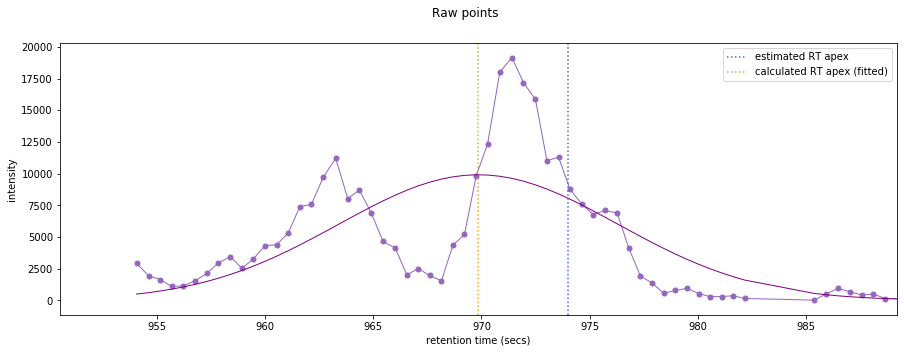

In [367]:
# visualise the monoisotopic peak in the RT dimension
f, ax = plt.subplots()
ax.plot(rt_df.retention_time_secs, rt_df.intensity, marker='o', color='tab:purple', linestyle='-', linewidth=1, ms=5)
plt.axvline(x=estimated_rt_apex, linestyle=':', color='royalblue', label='estimated RT apex')
if rt_curve_fit:
    plt.axvline(x=rt_apex_fitted, linestyle=':', color='orange', label='calculated RT apex (fitted)')
    ax.plot(rt_df.retention_time_secs, g, marker='', color='purple', linestyle='-', linewidth=1, ms=5)
else:
    plt.axvline(x=rt_apex_centroid, linestyle=':', color='coral', label='calculated RT apex (centroid)')
    plt.axvline(x=rt_apex_max, linestyle=':', color='seagreen', label='calculated RT apex (max)')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
plt.xlim((rt_lower,rt_upper))
plt.suptitle('Raw points')
plt.margins(0.06)
plt.show()

Calculate the feature metrics

In [ ]:
delta_mz_ppm = 